In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
df = spark.read.format('csv').options(header='true').load('dbfs:/FileStore/shared_uploads/AAPL.csv').toPandas()

In [0]:
df['Date'] = pd.to_datetime(df['Date'])

In [0]:
subset_date_range = df[(df['Date'] >= '2017-01-01') & (df['Date'] <= '2020-01-01')]

In [0]:
df = subset_date_range[['Date','Close']]

In [0]:
df.describe()

<command-3606984972888207>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe()


,Date,Close
count,754,754
unique,754,726
top,2017-01-03 00:00:00,172.5
freq,1,3
first,2017-01-03 00:00:00,NaN
last,2019-12-31 00:00:00,NaN


In [0]:
df.loc[:, 'Close'] = pd.to_numeric(df['Close'], errors='coerce')

<command-1691541051427003>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Close'] = pd.to_numeric(df['Close'], errors='coerce')


In [0]:
df['new'] = df['Close'].diff()

<command-1691541051426999>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['new'] = df['Close'].diff()


In [0]:
df.dropna(inplace=True)

<command-1691541051427005>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [0]:
new_df = df[['Date','new']]

In [0]:
new_df = spark.createDataFrame(new_df)

In [0]:
type(new_df)

Out[432]: pyspark.sql.dataframe.DataFrame

Out[400]: Text(0.5, 1.0, 'Closing value')

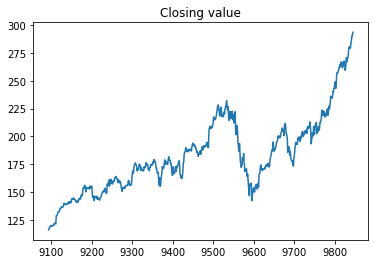

In [0]:
plt.plot(df['Close'])
plt.title('Closing value')

Out[401]: Text(0.5, 1.0, 'First order difference values')

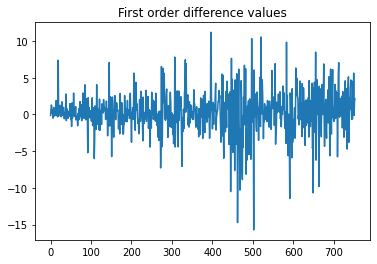

In [0]:
plt.plot(np.arange(0,len(df['new'])),df['new'])
plt.title('First order difference values')

In [0]:
from statsmodels.tsa.stattools import adfuller

In [0]:
result = adfuller(df['Close'])

In [0]:
print('adf value:', result[0])
print('p-value:', result[1])
print('critical values:')
for i, j in result[4].items():
    print(f"\t{i}: {j:.3f}")

adf value: 0.25746024996128103
p-value: 0.9753063642144683
critical values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [0]:
result = adfuller(df['new'])

In [0]:
print('adf value:', result[0])
print('p-value:', result[1])
print('critical values:')
for i, j in result[4].items():
    print(f"\t{i}: {j:.3f}")

adf value: -8.869000824390776
p-value: 1.4146837931201313e-14
critical values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [0]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<Figure size 864x288 with 0 Axes>

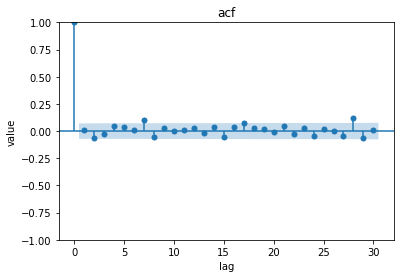

/databricks/python/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 864x288 with 0 Axes>

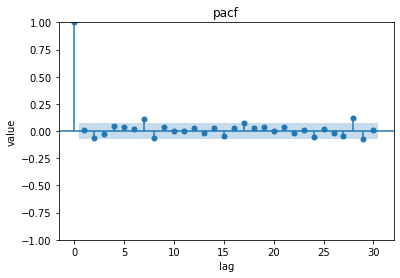

In [0]:
plt.figure(figsize=(12, 4))
plot_acf(df['new'], lags=30, alpha=0.05)
plt.title('acf')
plt.xlabel('lag')
plt.ylabel('value')
plt.show()
plt.figure(figsize=(12, 4))
plot_pacf(df['new'], lags=30, alpha=0.05)
plt.title('pacf')
plt.xlabel('lag')
plt.ylabel('value')
plt.show()

In [0]:
from pyspark import SparkContext

def lreg(X_rdd, y_rdd, learning_rate=0.01, epochs=100):
    slope = 0
    intercept = 0
    for epoch in range(epochs):
        y_pred_rdd = X_rdd.map(lambda x: x * slope + intercept)
        gradients = X_rdd.zip(y_rdd).map(lambda xy: (xy[1][0] - xy[0][0] * slope - intercept, xy[1][0] - xy[0][0] * slope * xy[0][0] - intercept * xy[0][0]))
        d_intercept = (-2 / X_rdd.count()) * gradients.map(lambda grad: grad[0]).sum()
        d_slope = (-2 / X_rdd.count()) * gradients.map(lambda grad: grad[1]).sum()
        slope -= learning_rate * d_slope
        intercept -= learning_rate * d_intercept    
    return slope, intercept

In [0]:
from pyspark.sql import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import lag

In [0]:
from pyspark.sql import Row
from pyspark.sql.functions import col, sqrt
def AR(spark_df, p):
    for i in range(1, p + 1):
        col_name = "Shifted_values_" + str(i)
        spark_df = spark_df.withColumn(col_name, lag("new", i).over(Window.orderBy("Date")))
    spark_df = spark_df.na.drop()
    train_size = int(0.8 * spark_df.count())
    train_df = spark_df.limit(train_size)
    test_df = spark_df.subtract(train_df)
    xt = train_df.rdd.map(lambda row : row[2:])
    yt = train_df.rdd.map(lambda row : row[1:2]) 
    s,l = lreg(xt,yt)
    spark_df = spark_df.withColumn("Predicted",(col("Shifted_values_1")*s)+l)
    spark_df = spark_df.withColumn("Subtracted",col("new") - col("Predicted"))
    squared_error = (col("new") - col("Predicted"))**2
    rmse = spark_df.select(sqrt((1/spark_df.count()) * squared_error).alias("RMSE")).collect()[0]["RMSE"]
    return spark_df,s,l,rmse

In [0]:
a,b,c,d = AR(new_df,1)

In [0]:
def MA(spark_df,q):
    for i in range(1, q + 1):
        col_name = "Subtracted_values_" + str(i)
        spark_df = spark_df.withColumn(col_name, lag("Subtracted", i).over(Window.orderBy("Date")))
    spark_df = spark_df.na.drop()
    train_size = int(0.8 * spark_df.count())
    train_df = spark_df.limit(train_size)
    test_df = spark_df.subtract(train_df)
    xt = train_df.rdd.map(lambda row : row[5:6])
    yt = train_df.rdd.map(lambda row : row[4:5]) 
    s,l = lreg(xt,yt)
    spark_df = spark_df.withColumn("Predicted_1",(col("Subtracted_values_1")*s)+l)
    return spark_df,s,l

In [0]:
x,y,z = MA(a,1)

In [0]:
x = x.withColumn("Final",col("Predicted") + col("Predicted_1"))

In [0]:
x = x.select("new","Final")

In [0]:
x = x.toPandas()

In [0]:
x['original'] = x['new'].cumsum()
x['pred'] = x['Final'].cumsum()

Out[402]: Text(0.5, 1.0, 'Original values')

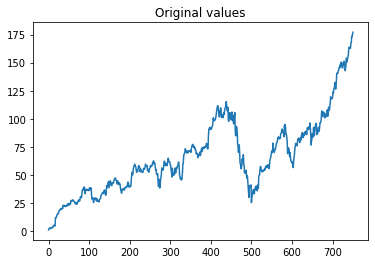

In [0]:
plt.plot(x['original'])
plt.title('Original values')

Out[403]: Text(0.5, 1.0, 'predicted values')

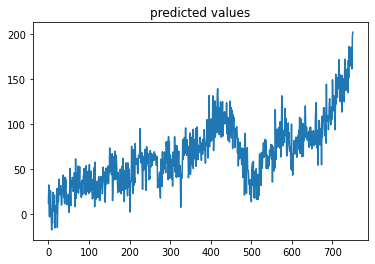

In [0]:
plt.plot(x['pred'])
plt.title('predicted values')

In [0]:
x['diff'] = (x['original']-x['pred'])**2
mse = np.mean(x['diff'])
rmse = np.sqrt(mse)

In [0]:
rmse

Out[391]: 14.163890154020002

In [0]:
test_df = spark.read.format('csv').options(header='true').load('dbfs:/FileStore/shared_uploads/test.csv').toPandas()

In [0]:
test_df['Date'] = pd.to_datetime(test_df['Date'])

In [0]:
test_df = test_df[['Date','Close']]

In [0]:
test_df.loc[:, 'Close'] = pd.to_numeric(test_df['Close'], errors='coerce')

<command-2078896744434025>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:, 'Close'] = pd.to_numeric(test_df['Close'], errors='coerce')


In [0]:
test_df['new'] = test_df['Close'].diff()

<command-2078896744434023>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['new'] = test_df['Close'].diff()


In [0]:
test_df.dropna(inplace=True)

<command-2078896744434024>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.dropna(inplace=True)


In [0]:
test_df = test_df[['Date','new']]

In [0]:
test_df = spark.createDataFrame(test_df)

In [0]:
a,b,c,d = AR(test_df,1)

In [0]:
x,y,z = MA(a,1)

In [0]:
x = x.withColumn("Final",col("Predicted") + col("Predicted_1"))

In [0]:
x = x.select("new","Final")

In [0]:
x['original'] = x['new'].cumsum()
x['pred'] = x['Final'].cumsum()

Out[438]: Text(0.5, 1.0, 'Unknown data')

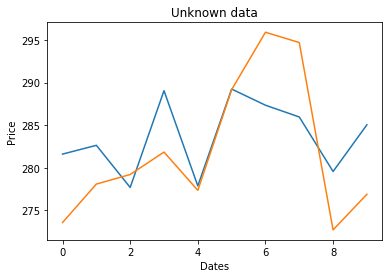

In [0]:
plt.plot(x['original'])
plt.plot(x['pred'])
plt.ylabel('Price')
plt.xlabel('Dates')
plt.title('Unknown data')